In [2]:
import numpy as np
import pandas as pd
from glob import glob
import sys
from icecube import astro
sys.path.append('/home/apizzuto/Nova/scripts/')
from Novae import Nova
import matplotlib.pyplot as plt
from astropy.time import Time
import seaborn as sns
import matplotlib as mpl
plt.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')
%matplotlib inline
palette = sns.color_palette('colorblind')

In [3]:
def mids(arr):
    return arr[:-1] + (np.diff(arr) / 2.)

In [4]:
df = pd.read_csv('/home/apizzuto/Nova/Novae_details.csv')
#Sort them by start time
df = df.sort_values('Start Time (gamma ray)')

novae = []
for index, row in df.iterrows():
    a = Nova(row['Name'], -1*row['EPL gamma'], np.radians(row['RA (Deg)']), np.radians(row['Dec. (Deg)']), 
                row['Start Time (gamma ray)'], row['Duration (gamma ray)'], flux_norm=row['EPL flux']*1e-7, cutoff = row['EPL cutoff '])
    novae.append(a)

#Sort them by start time
#novae_starts = [n.center_time for n in novae]
#novae_starts, novae = zip(*sorted(zip(novae_starts, novae)))

#datafs = sorted(glob('/data/user/mlarson/combo_r129072/skylab/scripts/testing/GRECO/version-001-p00/IC86_*_data.npy'))
datafs = sorted(glob('/data/user/mlarson/combo_r129072/scripts/greco_online/skylab_dataset/v2/dataset_scripts/all_fields/IC86_*data.npy'))
datas = [np.load(dataf) for dataf in datafs]
mc = np.load('/data/user/mlarson/combo_r129072/skylab/scripts/testing/GRECO/version-001-p00/IC86_2012_mc.npy')
#grlfs = sorted(glob('/data/user/mlarson/combo_r129072/skylab/scripts/testing/GRECO/version-001-p00/GRL/IC86_*_data.npy'))
grlfs = sorted(glob('/data/user/mlarson/combo_r129072/scripts/greco_online/skylab_dataset/v2/dataset_scripts/all_fields/GRL/IC86_*data.npy'))
grls = [np.load(grlf) for grlf in grlfs]


In [5]:
vals, ts = [], []
uptime = []
col_ind = []

def find_nearest(array, values):
    array = np.asarray(array)
    idx = [(np.abs(array - value)).argmin() for value in values]
    return array[idx]

for grl, exp in zip(grls, datas):
    time_bins = np.arange(grl['start'][0], grl['stop'][-1], 14.)
    time_bins = np.append(time_bins, grl['stop'][-1])
    time_bins = find_nearest(grl['stop'], time_bins)
    h, b = np.histogram(exp['time'], bins = time_bins)
    b = mids(b)
    vals.append(h)
    ts.append(b)
    ut, b = np.histogram(grl['start'], bins = time_bins, weights = grl['livetime'])
    uptime.append(ut)

In [6]:
rates = [np.where(up != 0., v / (up * 86400.), 0.) for up, v in zip(uptime, vals)]
val_err = [np.sqrt(v) for v in vals]
rate_err = [np.where(up != 0., v_err / (up * 86400.), 0.) for up, v_err in zip(uptime, val_err)]

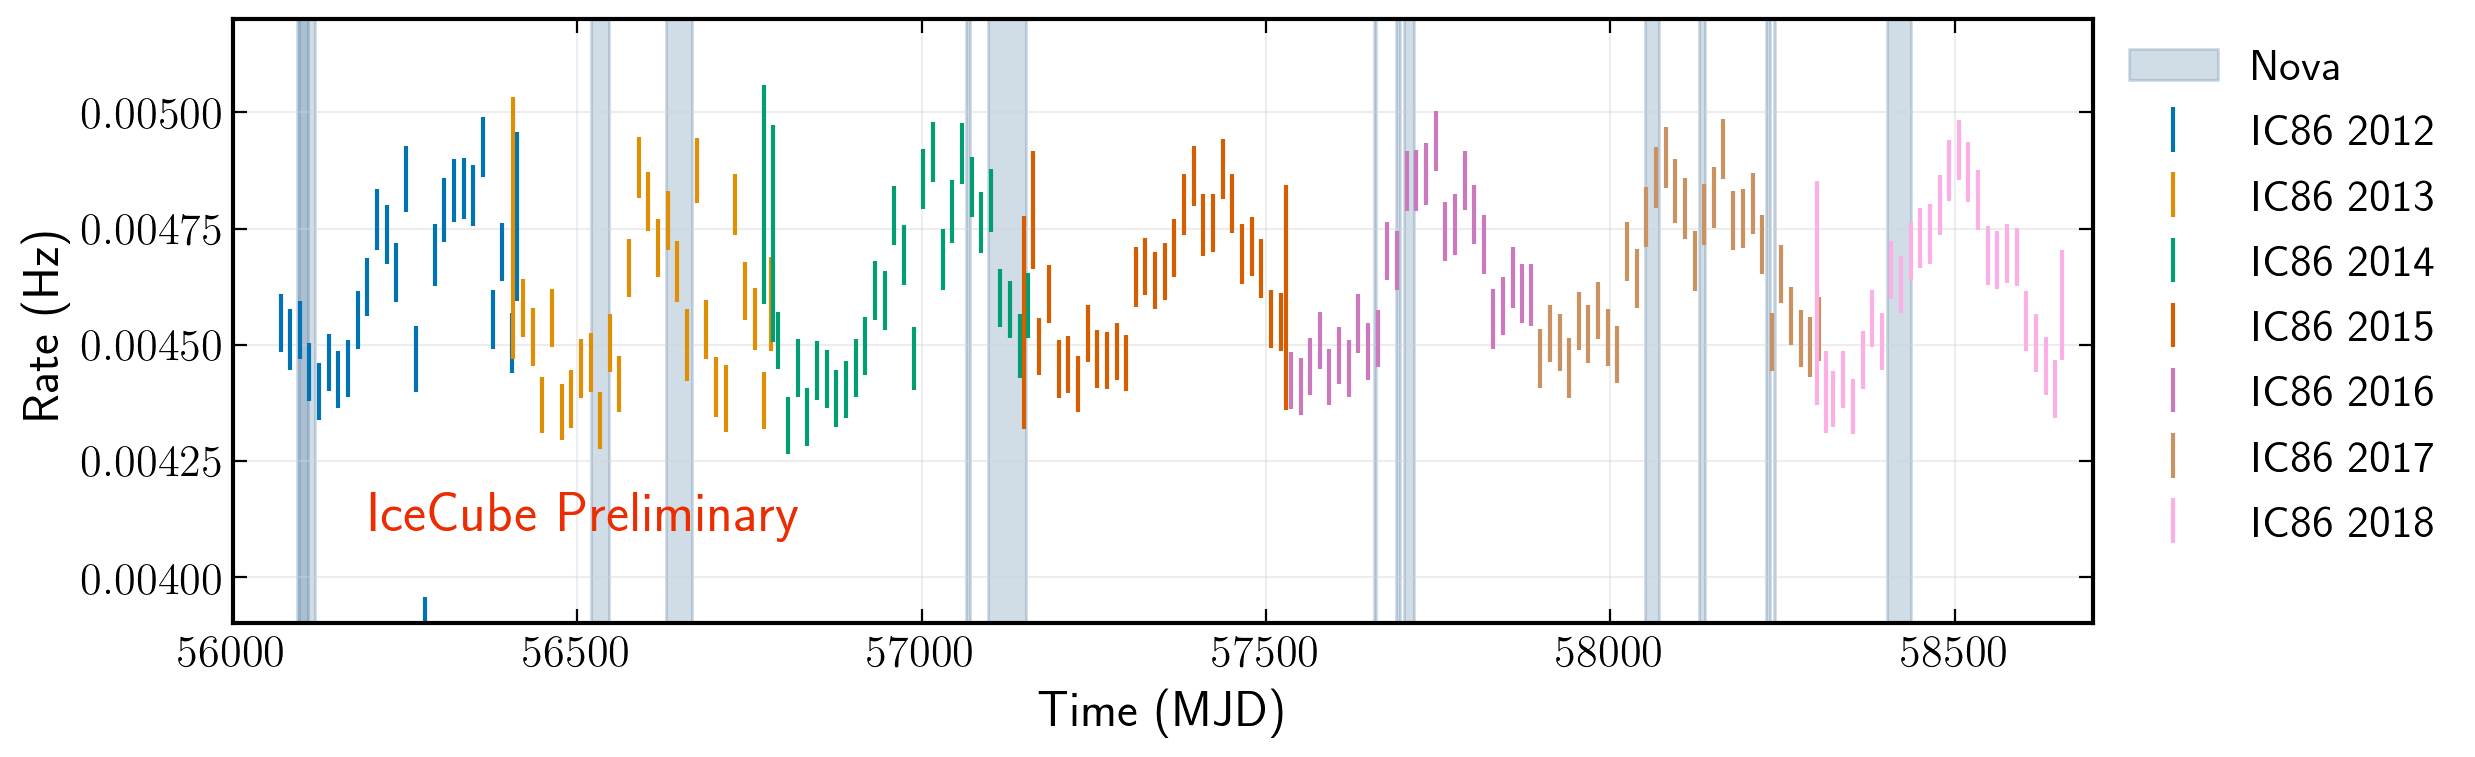

In [8]:
fig, ax = plt.subplots(figsize = (12, 4), dpi=200)

for i in range(len(ts)):
    plt.errorbar(ts[i], rates[i], yerr = rate_err[i], mec = palette[i], 
                 mfc = palette[i], ecolor = palette[i], ls = '', label = datafs[i][-18:-9].replace('_', ' '))

for jj, nova in enumerate(novae):
    if jj == 0:
        plt.axvspan(nova.center_time, nova.center_time + nova.time_sigma, 
                color = sns.xkcd_rgb['light navy'], alpha = 0.2, label = "Nova")
    else:
        plt.axvspan(nova.center_time, nova.center_time + nova.time_sigma, 
                color = sns.xkcd_rgb['light navy'], alpha = 0.2)
    
plt.legend(loc = (1.01, 0.1), frameon=False, fontsize = 16)
plt.xlim(56000, 58700)
plt.ylim(0.0039, 0.0052)
plt.ylabel('Rate (Hz)')
plt.xlabel('Time (MJD)')
plt.text(56200, 0.0041, 'IceCube Preliminary', color=sns.xkcd_rgb['tomato red'], fontsize=20)
plt.savefig('/home/apizzuto/public_html/novae/rates_with_novae_preliminary.png', 
            bbox_inches = 'tight', dpi = 150)
plt.show()

# Now, calculate livetime percentages for each Nova

In [7]:
def calc_nova_uptime(nova, grl):
    start = nova.center_time
    stop = nova.center_time + nova.time_sigma
    grlmsk = grl['stop'] > start
    grlmsk *= grl['start'] < stop
    runs = grl[grlmsk]
    total_cov = 0
    for run in runs:
        if run['start'] > start and run['stop'] < stop:
            total_cov += run['livetime']
        elif run['start'] < start:
            total_cov += run['stop'] - start
        elif run['stop'] > stop:
            total_cov += stop - run['start']
        else:
            print "why here?"
    return total_cov

def append_rows(arrayIN, NewRows):
    len_arrayIN = arrayIN.shape[0]
    len_NewRows = len(NewRows)
    arrayIN.resize(len_arrayIN + len_NewRows, refcheck=False)
    arrayIN[-len_NewRows:] = NewRows
    return arrayIN

def find_season(nova, grlsf):
    t = nova.center_time
    for grlf in grlsf:
        grl = np.load(grlf)
        if t > grl['start'][0] and t < grl['stop'][-1]:
            return grlf[-18:-9]
        #elif t > grl['start'][0]:
        #    return "WTF"
        #elif t < grl['stop'][-1]:
        #    return "WTF??"
        else:
            continue
    return None

In [8]:
for nova in novae:
    print find_season(nova, grlfs)

None
IC86_2012
IC86_2012
IC86_2013
IC86_2013
IC86_2014
IC86_2014
IC86_2016
IC86_2016
IC86_2016
None
None
None
None
None


In [9]:
master_grl = grls[0]
for grl in grls[1:]:
    master_grl = append_rows(master_grl, grl)
    
master_grl = np.unique(master_grl)

novae_livetimes = []
novae_season = []
for nova in novae:
    cov = calc_nova_uptime(nova, master_grl)
    nstart = Time(nova.center_time, format='mjd', scale = 'utc').iso
    print("nova start: {}\tnova duration: {:.1f}\tcoverage: {:.1f}\t percent: {:.1f}".format(nstart, nova.time_sigma, cov, cov * 100. / nova.time_sigma))
    novae_livetimes.append( cov / float(nova.time_sigma))
    novae_season.append(find_season(nova, grlfs))

nova start: 2010-03-10 00:00:00.000	nova duration: 22.0	coverage: 0.0	 percent: 0.0
nova start: 2012-06-15 00:00:00.000	nova duration: 17.0	coverage: 16.6	 percent: 97.6
nova start: 2012-06-19 00:00:00.000	nova duration: 22.0	coverage: 21.3	 percent: 96.9
nova start: 2013-08-16 00:00:00.000	nova duration: 27.0	coverage: 23.3	 percent: 86.2
nova start: 2013-12-02 09:50:24.000	nova duration: 39.0	coverage: 27.8	 percent: 71.4
nova start: 2015-02-10 23:59:57.000	nova duration: 7.0	coverage: 6.7	 percent: 95.2
nova start: 2015-03-15 15:12:57.600	nova duration: 55.0	coverage: 53.4	 percent: 97.1
nova start: 2016-09-26 00:00:00.000	nova duration: 3.0	coverage: 3.0	 percent: 100.0
nova start: 2016-10-28 00:00:00.000	nova duration: 5.0	coverage: 4.7	 percent: 93.3
nova start: 2016-11-08 00:00:00.000	nova duration: 15.0	coverage: 14.8	 percent: 99.0
nova start: 2017-10-24 00:00:00.000	nova duration: 20.0	coverage: 0.0	 percent: 0.0
nova start: 2018-01-11 00:00:00.000	nova duration: 8.0	coverage

In [10]:
df['GRECO livetime'] = novae_livetimes

In [11]:
df['GRECO season'] = novae_season

In [12]:
df

,Name,Class,Distance (kpc),Start Time (gamma ray),Duration (gamma ray),Peak Date (optical),RA (Deg),Dec. (Deg),SPL gamma,SPL gamma error,...,EPL cutoff,EPL cutoff error,EPL integrated flux,EPL integrated flux error,EPL flux,EPL flux error,Source,Notes,GRECO livetime,GRECO season
0,V407 Cyg 2010,NaN,2.7,55265.000000,22,2010-03-10,315.5409,45.7758,2.11,0.06,...,1.44,0.36,4.30,0.54,1.570420,0.197216,Fermi-I,NaN,0.000000,None
1,V1324 Sco 2012,NaN,4.5,56093.000000,17,2012-06-19,267.7246,-32.6224,2.16,0.09,...,4.10,6.14,4.93,2.45,0.754379,0.374894,Fermi-I,NaN,0.976413,IC86_2012
2,V959 Mon 2012,NaN,3.6,56097.000000,22,NaN,99.9108,5.8980,2.34,0.09,...,1.45,0.61,4.13,0.60,0.836455,0.121519,Fermi-I,NaN,0.968551,IC86_2012
3,V339 Del 2013,NaN,4.2,56520.000000,27,2013-08-16,305.8792,20.7681,2.26,0.08,...,1.94,0.95,1.93,0.29,0.325371,0.052947,Fermi-I,NaN,0.861887,IC86_2013
4,V1369 Cen 2013,NaN,2.5,56628.410000,39,2013-12-5,208.6958,-59.1522,2.37,0.09,...,2.30,1.00,2.11,4.20,0.316163,0.629329,Fermi-II,NaN,0.713826,IC86_2013
7,V1535 Sco,NaN,7.3,57063.999965,7,NaN,255.8590,35.0716,2.30,0.30,...,4.30,1.20,1.00,0.30,0.127765,0.038329,Fermi-III (Anna),NaN,0.951569,IC86_2014
5,V5668 Sgr 2015,NaN,2.0,57096.634000,55,2015-03-21,5.3799,-28.9283,2.42,0.13,...,9.00,14.00,1.09,0.24,0.077203,0.016999,Fermi-II,NaN,0.971490,IC86_2014
14,V407 Lup (ASASSN-16kt),NaN,NaN,57657.000000,3,NaN,232.2576,-44.8280,2.20,0.20,...,4.30,2.00,1.80,0.60,0.229976,0.076659,http://www.astronomerstelegram.org/?read=9594,NaN,0.999523,IC86_2016
13,V5855 Sgr (TCP J18102829-2729590),NaN,NaN,57689.000000,5,NaN,272.6179,-27.4997,2.20,0.20,...,4.30,2.00,2.60,0.70,0.332188,0.089435,http://www.astronomerstelegram.org/?read=9699,NaN,0.932775,IC86_2016
8,ASASSN-16ma,NaN,4.2,57700.000000,15,2016-11-07 22:48:00,275.2177,-28.3700,2.11,0.05,...,5.90,2.60,5.40,0.50,0.709619,0.065705,Nova outburst powered by shocks,NaN,0.989734,IC86_2016


In [16]:
df.columns
prows = [u'Name', u'Start Time (gamma ray)', u'Duration (gamma ray)', u'GRECO season', u'GRECO livetime']
df[prows]

,Name,Start Time (gamma ray),Duration (gamma ray),GRECO season,GRECO livetime
0,V407 Cyg 2010,55265.000000,22,None,0.000000
1,V1324 Sco 2012,56093.000000,17,IC86_2012,0.976413
2,V959 Mon 2012,56097.000000,22,IC86_2012,0.968551
3,V339 Del 2013,56520.000000,27,IC86_2013,0.861887
4,V1369 Cen 2013,56628.410000,39,IC86_2013,0.713826
7,V1535 Sco,57063.999965,7,IC86_2014,0.951569
5,V5668 Sgr 2015,57096.634000,55,IC86_2014,0.971490
14,V407 Lup (ASASSN-16kt),57657.000000,3,IC86_2016,0.999523
13,V5855 Sgr (TCP J18102829-2729590),57689.000000,5,IC86_2016,0.932775
8,ASASSN-16ma,57700.000000,15,IC86_2016,0.989734


In [27]:
df.to_pickle('/home/apizzuto/Nova/Novae_details_with_seasons.csv')

In [28]:
df = pd.read_pickle('/home/apizzuto/Nova/Novae_details_with_seasons.csv')

In [29]:
df

,Name,Class,Distance (kpc),Start Time (gamma ray),Duration (gamma ray),Peak Date (optical),RA (Deg),Dec. (Deg),SPL gamma,SPL gamma error,...,EPL cutoff,EPL cutoff error,EPL integrated flux,EPL integrated flux error,EPL flux,EPL flux error,Source,Notes,GRECO livetime,GRECO season
0,V407 Cyg 2010,NaN,2.7,55265.000000,22,2010-03-10,315.5409,45.7758,2.11,0.06,...,1.44,0.36,4.30,0.54,1.570420,0.197216,Fermi-I,NaN,0.000000,None
1,V1324 Sco 2012,NaN,4.5,56093.000000,17,2012-06-19,267.7246,-32.6224,2.16,0.09,...,4.10,6.14,4.93,2.45,0.754379,0.374894,Fermi-I,NaN,0.976413,IC86_2012
2,V959 Mon 2012,NaN,3.6,56097.000000,22,NaN,99.9108,5.8980,2.34,0.09,...,1.45,0.61,4.13,0.60,0.836455,0.121519,Fermi-I,NaN,0.968551,IC86_2012
3,V339 Del 2013,NaN,4.2,56520.000000,27,2013-08-16,305.8792,20.7681,2.26,0.08,...,1.94,0.95,1.93,0.29,0.325371,0.052947,Fermi-I,NaN,0.861887,IC86_2013
4,V1369 Cen 2013,NaN,2.5,56628.410000,39,2013-12-5,208.6958,-59.1522,2.37,0.09,...,2.30,1.00,2.11,4.20,0.316163,0.629329,Fermi-II,NaN,0.713826,IC86_2013
7,V1535 Sco,NaN,7.3,57063.999965,7,NaN,255.8590,35.0716,2.30,0.30,...,4.30,1.20,1.00,0.30,0.127765,0.038329,Fermi-III (Anna),NaN,0.951569,IC86_2014
5,V5668 Sgr 2015,NaN,2.0,57096.634000,55,2015-03-21,5.3799,-28.9283,2.42,0.13,...,9.00,14.00,1.09,0.24,0.077203,0.016999,Fermi-II,NaN,0.971490,IC86_2014
14,V407 Lup (ASASSN-16kt),NaN,NaN,57657.000000,3,NaN,232.2576,-44.8280,2.20,0.20,...,4.30,2.00,1.80,0.60,0.229976,0.076659,http://www.astronomerstelegram.org/?read=9594,NaN,0.999523,IC86_2016
13,V5855 Sgr (TCP J18102829-2729590),NaN,NaN,57689.000000,5,NaN,272.6179,-27.4997,2.20,0.20,...,4.30,2.00,2.60,0.70,0.332188,0.089435,http://www.astronomerstelegram.org/?read=9699,NaN,0.932775,IC86_2016
8,ASASSN-16ma,NaN,4.2,57700.000000,15,2016-11-07 22:48:00,275.2177,-28.3700,2.11,0.05,...,5.90,2.60,5.40,0.50,0.709619,0.065705,Nova outburst powered by shocks,NaN,0.989734,IC86_2016


In [32]:
print df.to_latex().replace('\n', '')

\begin{tabular}{llrrrrlrrrrrrrrrrrrrrrrllr}\toprule{} &                               Name &  Class &  Distance (kpc) &  Start Time (gamma ray) &  Duration (gamma ray) &  Peak Date (optical) &  RA (Deg) &  Dec. (Deg) &  SPL gamma &  SPL gamma error &  SPL integrated flux &  SPL integrated flux error &  SPL flux &  SPL flux error &  EPL gamma &  EPL gamma error &  EPL cutoff  &  EPL cutoff error &  EPL integrated flux &  EPL integrated flux error &  EPL flux &  EPL flux error &                                          Source &                            Notes &  GRECO livetime \\\midrule0  &                      V407 Cyg 2010 &    NaN &             2.7 &            55265.000000 &                    22 &           2010-03-10 &  315.5409 &     45.7758 &       2.11 &             0.06 &                 5.77 &                       0.55 &  0.497163 &        0.047390 &       1.23 &             0.20 &         1.44 &              0.36 &                 4.30 &                       0.54 &  1.570